In [19]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))
import flares

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr
from matplotlib.colors import Normalize
from scipy.stats import binned_statistic
from unyt import erg, s

from synthesizer.grid import Grid
from synthesizer.emission_models.agn.models import DiscIncidentEmission
from synthesizer.particle import BlackHoles

from flares_utility.stats import weighted_median, binned_weighted_quantile
# import utils as u




# Set a random number seed to ensure consistent results
np.random.seed(42)

In [20]:
# set style
plt.style.use('../matplotlibrc.txt')

In [21]:

tag = flares.tags[-1]
print(tag)
quantities = flares.get_quantities(tag, group='details')

blackhole_mass = quantities['blackhole_masses'].to('Msun')
blackhole_accretion_rate = quantities['accretion_rates']['10'].to('Msun/yr')
bolometric_luminosity = quantities['bolometric_luminosities']['10']
eddington_ratio = quantities['eddington_ratios']['10']
weights = quantities['weights']
stellar_halpha_luminosity = quantities['attenuated_stellar_halpha_luminosity'] * erg/s
intrinsic_stellar_halpha_luminosity = quantities['intrinsic_stellar_halpha_luminosity'] * erg/s

# print(blackhole_mass)
print('total number of BHs', len(blackhole_mass))

selection = (blackhole_mass.to('Msun').value > 1E6) & (bolometric_luminosity.to('erg/s').value > 1E44)

selection = bolometric_luminosity.to('erg/s').value > 1E30

print(np.sum(selection))

stellar_halpha_luminosity = stellar_halpha_luminosity[selection]
intrinsic_stellar_halpha_luminosity = intrinsic_stellar_halpha_luminosity[selection]
blackhole_mass = blackhole_mass[selection]
blackhole_accretion_rate = blackhole_accretion_rate[selection]
bolometric_luminosity = bolometric_luminosity[selection]
weights = weights[selection]

conservative_selection = (blackhole_mass.to('Msun').value > 1E7) & (bolometric_luminosity.to('erg/s').value > 1E45)

print(np.sum(conservative_selection))


selection_label = r'$\rm M_{\bullet}>10^{6}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$'
conservative_selection_label = r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{45}\ {\rm erg\ s^{-1}}$'


010_z005p000
total number of BHs 237437
6405
153


Check we're not missing lots of bright H\alpha emitting galaxies with this criteria

First we need to initialise our `BlackHole` object with the parameters that will be needed to compute spectra.

In [22]:

blackholes = BlackHoles(
    masses=blackhole_mass,
    accretion_rates=blackhole_accretion_rate,
)

In [23]:

grid_name = 'qsosed-isotropic'
grid_dir = "/Users/sw376/Dropbox/Research/data/synthesizer/grids/"

grid = Grid(
    grid_name=grid_name, 
    grid_dir=grid_dir,
    read_lines=False)

In [24]:

emission_model = DiscIncidentEmission(grid)


In [25]:
# get the spectra assuming this emission model
blackholes.get_particle_spectra(emission_model)


spectra = blackholes.particle_spectra['disc_incident']

ionising_photon_luminosity = spectra.calculate_ionising_photon_production_rate()

ionising_bolometric_correction = ionising_photon_luminosity/spectra.bolometric_luminosity

agn_halpha_luminosity = ionising_photon_luminosity * flares.ionising_to_Halpha_conversion





#### Calculate the total H$\alpha$ luminosity

In [27]:

print(np.min(agn_halpha_luminosity), np.max(agn_halpha_luminosity))

total_halpha_luminosity = agn_halpha_luminosity + stellar_halpha_luminosity


4.9389180999917167e+36 erg/s 2.7314033032270022e+45 erg/s


## Compare stellar and AGN h-alpha

In [28]:
luminosity_ratio = agn_halpha_luminosity.to('erg/s').value / stellar_halpha_luminosity.to('erg/s').value

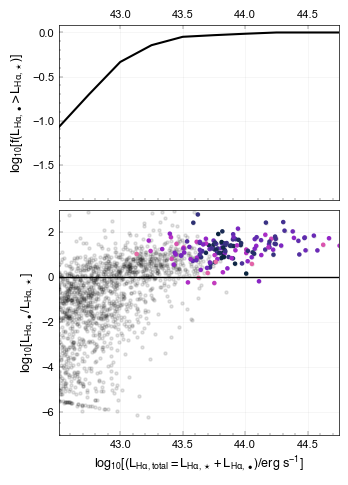

In [29]:
xlimits = np.array([42.51, 44.75])  # log10(erg/s)
ylimits = np.array([-7., 2.99])
 

fig = plt.figure(figsize = (3.5, 5.))

left  = 0.15
height = 0.45
bottom = 0.1
width = 0.8
fheight = 0.35

ax = fig.add_axes((left, bottom, width, height))
# cax = fig.add_axes([left, bottom+height, width, 0.03])
fax = fig.add_axes([left, bottom+height+0.02, width, fheight])


norm = Normalize(vmin=7., vmax=9.5)
cmap = cmr.bubblegum
n = norm




# EVERYTHING
ax.scatter(np.log10(total_halpha_luminosity.to('erg/s').value), 
           np.log10(luminosity_ratio),
           s=5,
           zorder=1,
           c='k',
           alpha=0.1)

#  meeting conservative selection
ax.scatter(np.log10(total_halpha_luminosity[conservative_selection].to('erg/s').value), 
           np.log10(luminosity_ratio[conservative_selection]),
           s=5,
           zorder=1,
           c=cmap(norm(np.log10(blackholes.masses[conservative_selection].to('Msun').value))))


# fraction plot
bins = np.arange(41.625, 45., 0.25)
bin_centres = 0.5*(bins[1:]+bins[:-1])
Nall, _ = np.histogram(np.log10(total_halpha_luminosity), bins=bins)
Nagn, _ = np.histogram(np.log10(total_halpha_luminosity[luminosity_ratio>1.]), bins=bins)

fraction = Nagn/Nall
fax.plot(bin_centres, np.log10(fraction), c='k')

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
# ax.set_yscale('log')

ax.set_xlabel(r'$\rm log_{10}[(L_{H\alpha, total}=L_{H\alpha,\star}+L_{H\alpha,\bullet})/erg\ s^{-1}]$')
ax.set_ylabel(r'$\rm log_{10}[L_{H\alpha,\bullet}/L_{H\alpha,\star}]$')

ax.axhline(0.0, c='k', lw=1)
ax.legend(fontsize=7)

# fax.set_xticks([])
fax.set_xlim(xlimits)
fax.set_ylabel(r'$\rm log_{10}[f(L_{H\alpha,\bullet}>L_{H\alpha,\star})]$')
fax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

# # add colourbar
# cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)
# fig.colorbar(cmapper, cax=cax, orientation='horizontal')
# cax.xaxis.tick_top()
# cax.xaxis.set_label_position('top')
# cax.set_xlabel(r'$\rm log_{10}(\dot{M}_{\bullet}/M_{\odot})$', fontsize=7)
# cax.tick_params(axis='x', labelsize=6)

# ax.set_yticks([9.5,])
# ax.set_xticks([45., 45.5, 46., 46.5])

filename = f'figures/stellar_agn_relative.pdf'
fig.savefig(filename)
plt.show()
fig.clf()

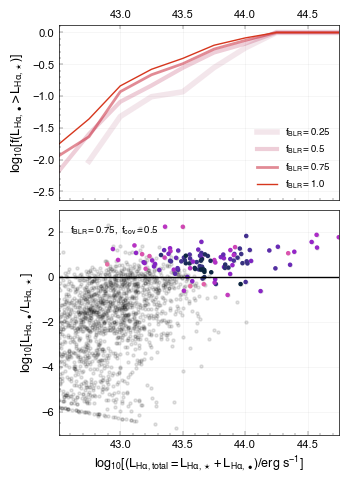

In [31]:
xlimits = np.array([42.51, 44.75])  # log10(erg/s)
ylimits = np.array([-7., 2.99])
 

fig = plt.figure(figsize = (3.5, 5.))

left  = 0.15
height = 0.45
bottom = 0.1
width = 0.8
fheight = 0.35

ax = fig.add_axes((left, bottom, width, height))
# cax = fig.add_axes([left, bottom+height, width, 0.03])
fax = fig.add_axes([left, bottom+height+0.02, width, fheight])


norm = Normalize(vmin=7., vmax=9.5)
cmap = cmr.bubblegum
n = norm



# apply covering fraction correction
fcov = 0.5
f_blr = 0.75

agn_halpha_luminosity_ = fcov * agn_halpha_luminosity

ntot = len(agn_halpha_luminosity)
size = int(ntot * f_blr)

fblr_selection = np.zeros(ntot, dtype=bool)
fblr_selection[np.random.choice(np.arange(0, ntot), size=size, replace=False)] = True

# set the AGN luminosity of the obscured AGN to zero
agn_halpha_luminosity_[~fblr_selection] = 0.0

# calculate total luminosity
total_halpha_luminosity_ = agn_halpha_luminosity_ + intrinsic_stellar_halpha_luminosity

# calculate luminosity ratio
luminosity_ratio_ = agn_halpha_luminosity_.to('erg/s').value / intrinsic_stellar_halpha_luminosity.to('erg/s').value



# EVERYTHING
ax.scatter(np.log10(total_halpha_luminosity_.to('erg/s').value), 
           np.log10(luminosity_ratio_),
           s=5,
           zorder=1,
           c='k',
           alpha=0.1)

#  meeting conservative selection
ax.scatter(np.log10(total_halpha_luminosity_[conservative_selection].to('erg/s').value), 
           np.log10(luminosity_ratio_[conservative_selection]),
           s=5,
           zorder=1,
           c=cmap(norm(np.log10(blackholes.masses[conservative_selection].to('Msun').value))))



colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))

for f_blr, lw, alpha, col in zip([0.25, 0.5, 0.75, 1.0], [4,3,2,1], [0.1, 0.2, 0.5, 1.0], colours):

    # apply covering fraction correction
    fcov = 0.5
    agn_halpha_luminosity_ = fcov * agn_halpha_luminosity

    ntot = len(agn_halpha_luminosity)
    size = int(ntot * f_blr)

    fblr_selection = np.zeros(ntot, dtype=bool)
    fblr_selection[np.random.choice(np.arange(0, ntot), size=size, replace=False)] = True

    # set the AGN luminosity of the obscured AGN to zero
    agn_halpha_luminosity_[~fblr_selection] = 0.0

    # calculate total luminosity
    total_halpha_luminosity_ = agn_halpha_luminosity_ + intrinsic_stellar_halpha_luminosity

    # calculate luminosity ratio
    luminosity_ratio_ = agn_halpha_luminosity_.to('erg/s').value / intrinsic_stellar_halpha_luminosity.to('erg/s').value

    # fraction plot
    bins = np.arange(41.625, 45., 0.25)
    bin_centres = 0.5*(bins[1:]+bins[:-1])
    Nall, _ = np.histogram(np.log10(total_halpha_luminosity_), bins=bins)
    Nagn, _ = np.histogram(np.log10(total_halpha_luminosity_[luminosity_ratio_>1.]), bins=bins)

    fraction = Nagn/Nall
    fax.plot(
        bin_centres, 
        np.log10(fraction), 
        c=col, 
        lw=lw, 
        alpha=alpha, 
        ls='-', 
        label=rf'$\rm f_{{BLR}}={f_blr}$')


fax.legend(fontsize=7)


ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
# ax.set_yscale('log')

ax.set_xlabel(r'$\rm log_{10}[(L_{H\alpha, total}=L_{H\alpha,\star}+L_{H\alpha,\bullet})/erg\ s^{-1}]$')
ax.set_ylabel(r'$\rm log_{10}[L_{H\alpha,\bullet}/L_{H\alpha,\star}]$')

ax.axhline(0.0, c='k', lw=1)
# ax.legend(fontsize=7)
ax.text(42.6, 2.0, r'$\rm f_{BLR}=0.75,\ f_{cov}=0.5$', fontsize=7)


# fax.set_xticks([])
fax.set_xlim(xlimits)
fax.set_ylabel(r'$\rm log_{10}[f(L_{H\alpha,\bullet}>L_{H\alpha,\star})]$')
fax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)


filename = f'figures/stellar_agn_relative.pdf'
fig.savefig(filename)
plt.show()
fig.clf()